# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
#conda install tensorflow

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::holoviews==1.14.8=pyhd3eb1b0_0
  - defaults/osx-64::anaconda-navigator==2.2.0=py39hecd8cb5_0
  - defaults/noarch::s3transfer==0.5.0=pyhd3eb1b0_0
  - defaults/noarch::requests-file==1.5.1=pyhd3eb1b0_0
  - defaults/noarch::smart_open==5.1.0=pyhd3eb1b0_0
  - defaults/noarch::boto3==1.21.32=pyhd3eb1b0_0
  - defaults/noarch::cookiecutter==1.7.3=pyhd3eb1b0_0
  - defaults/noarch::google-cloud-core==1.7.1=pyhd3eb1b0_0
  - defaults/osx-64::anaconda==2022.05=py39_0
  - defaults/osx-64::conda==4.13.0=py39hecd8cb5_0
  - defaults/noarch::datashader==0.13.0=pyhd3eb1b0_1
  - defaults/noarch::conda-repo-cli==1.0.4=pyhd3eb1b0_0
  - defaults/osx-64::conda-build==3.21.8=py39hecd8cb5_2
  - defaults/noarch::sphinx==4.4.0=pyhd3eb1b0_0
  - defaults/noarch::numpydoc==1.2=pyhd3eb1b0_0
  - defaults/osx-64::scrapy==2.6.1=py39hecd8cb5_0
  - de

cctools_osx-64-949.0 | 1.3 MB    | ##################################### | 100% 
tensorflow-estimator | 491 KB    | ##################################### | 100% 
astunparse-1.6.3     | 17 KB     | ##################################### | 100% 
opt_einsum-3.3.0     | 57 KB     | ##################################### | 100% 
urllib3-1.26.14      | 194 KB    | ##################################### | 100% 
keras-preprocessing- | 35 KB     | ##################################### | 100% 
tensorboard-data-ser | 2.8 MB    | ##################################### | 100% 
re2-2022.04.01       | 179 KB    | ##################################### | 100% 
tensorboard-2.9.0    | 5.5 MB    | ##################################### | 100% 
ca-certificates-2023 | 121 KB    | ##################################### | 100% 
anaconda-custom      | 4 KB      | ##################################### | 100% 
grpc-cpp-1.46.1      | 2.5 MB    | ##################################### | 100% 
requests-oauthlib-1. | 23 KB

In [3]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [3]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + Logreg
start = time.time()
rff = RFFPipeline() 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF + Logreg: accuracy = {acc1}, time = {end}')

PCA + RFF + Logreg: accuracy = 0.8584, time = 20.155084133148193


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [14]:
#kernel SVM on initial data
start_train = time.time()
SVM_k_initial = SVC(kernel='rbf', random_state=0).fit(x_train, y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred_SVM_k_initial = SVM_k_initial.predict(x_test)
end_test = time.time() - start_test 
acc2 = accuracy_score(y_test, y_pred_SVM_k_initial)
print(f'Kernel SVM on initial data: accuracy = {acc2}, training time = {end_train}, testing time = {end_test}')

Kernel SVM on initial data: accuracy = 0.8828, training time = 297.6544988155365, testing time = 70.27885007858276


In [15]:
#linear SVM on initial data
start_train = time.time()
SVM_initial = SVC(random_state=0).fit(x_train, y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred_SVM_initial = SVM_initial.predict(x_test)
end_test = time.time() - start_test
acc3 = accuracy_score(y_test, y_pred_SVM_initial)
print(f'Linear SVM on initial data: accuracy = {acc3}, training time = {end_train}, testing time = {end_test}')


Linear SVM on initial data: accuracy = 0.8828, training time = 298.08090686798096, testing time = 70.39896392822266


In [17]:
#PCA + RFF + linear SVM
start_train = time.time()
rff_PCA_SVM = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='svm') 
rff_PCA_SVM  = rff_PCA_SVM.fit(x_train, y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred_rff_PCA_SVM  = rff_PCA_SVM.predict(x_test)
end_test = time.time() - start_test
acc7 = accuracy_score(y_test, y_pred_rff_PCA_SVM)
print(f'PCA + RFF + linear SVM: accuracy = {acc7}, training time = {end_train}, testing time = {end_test}')


PCA + RFF + linear SVM: accuracy = 0.8688, training time = 260.63614106178284, testing time = 0.2239077091217041


In [16]:
#CatBoost with PCA
from catboost import CatBoostClassifier

start_train = time.time()
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)

cat = CatBoostClassifier(learning_rate = 0.03, depth = 10, verbose = False)
cat = cat.fit(x_train_pca, y_train)
end_train = time.time() - start_train
start_test = time.time()
x_test_pca = pca.transform(x_test)
y_pred_cat = cat.predict(x_test_pca)
end_test = time.time() - start_test
acc4 = accuracy_score(y_test, y_pred_cat)
print(f'CatBoost with PCA: accuracy = {acc4}, training time = {end_train}, testing time = {end_test}')


CatBoost with PCA: accuracy = 0.874, training time = 229.69751906394958, testing time = 0.1518232822418213


In [20]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + Logreg
start_train = time.time()
rff = RFFPipeline() 
rff = rff.fit(x_train, y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred = rff.predict(x_test)
end_test = time.time() - start_test
acc1 = accuracy_score(y_test, y_pred)
print(f'PCA + RFF + Logreg: accuracy = {acc1}, training time = {end_train}, testing time = {end_test}')


PCA + RFF + Logreg: accuracy = 0.8571, training time = 19.048567056655884, testing time = 0.23002195358276367


**Выводы:** как видим, каждый из представленных подходов дает примерно одинаковое высокое качество. 

При сравнении SVM на исходных данных с PCA + RFF + linear SVM можно сделать вывод, что третий вариант дает лучшие результаты с точки зрения времени: время и обучения, и применения ниже, чем у обоих вариантов SVM на исходных данных. 

Однако выигрышнее всех трех описанных выше вариантов оказался бустинг с PCA: результаты выше и с точки зрения качества, и с точки зрения времени. Но в сравнении бустинга с PCA + RFF + Logreg логрег со случайными признаками дает качество несильно ниже кэтбуста, но при этом время обучения значительно ниже у логистической регрессии. 

Таким образом, подход со случайными признаками кажется оптимальным вариантом, поскольку он дает такие же высокие метрики качества, но по времени оказывается быстрее. 

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

1) Исследуем влияние понижения размерности через PCA на результаты

In [18]:
#RFF + linear SVM
start_train = time.time()
rff_SVM = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier='svm') 
rff_SVM = rff_SVM.fit(x_train.astype(np.float64), y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred_rff_SVM = rff_SVM.predict(x_test)
end_test = time.time() - start_test
acc6 = accuracy_score(y_test, y_pred_rff_SVM)
print(f'RFF + linear SVM: accuracy = {acc6}, training time = {end_train}, testing time = {end_test}')


RFF + linear SVM: accuracy = 0.8566, training time = 281.3163697719574, testing time = 0.39263415336608887


In [17]:
#PCA + RFF + linear SVM
start_train = time.time()
rff_PCA_SVM = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='svm') 
rff_PCA_SVM  = rff_PCA_SVM.fit(x_train, y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred_rff_PCA_SVM  = rff_PCA_SVM.predict(x_test)
end_test = time.time() - start_test
acc7 = accuracy_score(y_test, y_pred_rff_PCA_SVM)
print(f'PCA + RFF + linear SVM: accuracy = {acc7}, training time = {end_train}, testing time = {end_test}')


PCA + RFF + linear SVM: accuracy = 0.8688, training time = 260.63614106178284, testing time = 0.2239077091217041


In [19]:
#RFF + Logreg
start_train = time.time()
rff_logreg = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier='logreg') 
rff_logreg = rff_logreg.fit(x_train.astype(np.float64), y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred_rff_logreg = rff_logreg.predict(x_test)
end_test = time.time() - start_test
acc5 = accuracy_score(y_test, y_pred_rff_logreg)
print(f'RFF + Logreg: accuracy = {acc5}, training time = {end_train}, testing time = {end_test}')


RFF + Logreg: accuracy = 0.8666, training time = 34.315184116363525, testing time = 0.4032912254333496


In [20]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + Logreg
start_train = time.time()
rff = RFFPipeline() 
rff = rff.fit(x_train, y_train)
end_train = time.time() - start_train
start_test = time.time()
y_pred = rff.predict(x_test)
end_test = time.time() - start_test
acc1 = accuracy_score(y_test, y_pred)
print(f'PCA + RFF + Logreg: accuracy = {acc1}, training time = {end_train}, testing time = {end_test}')


PCA + RFF + Logreg: accuracy = 0.8571, training time = 19.048567056655884, testing time = 0.23002195358276367


Значит, предварительное поонижение размерности с PCA позволяет снизить время обучения и применения модели, а также в некоторых случаях увеличить качество модели.  

2) Проверим зависимость качества от n_features

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
accuracies_l = []
accuracies_s = []
for i in [100, 250, 500, 1000, 2000, 3000]:
    #PCA + RFF + Logreg
    rff_logreg = RFFPipeline(n_features=i, new_dim=50, use_PCA=True, classifier='logreg') 
    rff_logreg = rff_logreg.fit(x_train.astype(np.float64), y_train)
    y_pred_logreg = rff_logreg.predict(x_test)
    acc_l = accuracy_score(y_test, y_pred_logreg)
    accuracies_l.append(acc_l)
    
    #PCA + RFF + linear SVM
    rff_svm = RFFPipeline(n_features=i, new_dim=50, use_PCA=True, classifier='svm') 
    rff_svm = rff_svm.fit(x_train.astype(np.float64), y_train)
    y_pred_svm = rff_svm.predict(x_test)
    acc_s = accuracy_score(y_test, y_pred_svm)
    accuracies_s.append(acc_s)

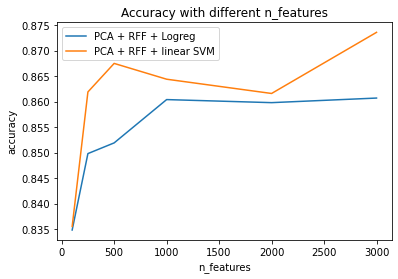

In [5]:
import matplotlib.pyplot as plt
x = [100, 250, 500, 1000, 2000, 3000]

plt.plot(x, accuracies_l, label='PCA + RFF + Logreg')
plt.plot(x, accuracies_s, label='PCA + RFF + linear SVM')
plt.legend()
plt.title('Accuracy with different n_features')
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.show()

Как видим, в случае с логрегом качество, и вправду, выходит на плато, однако качество на SVM продолжает расти с увеличением n_features.

3) Из всех проведенных выше экспериментов можно сделать вывод, что SVM дает более высокий результат с точки зрения качества, однако линейная регрессия гораздо быстрее обучается и применяется. Таким образом, выбор между моделями должен строиться относительно целей: в случае если требуется получить как можно более высокое качество, то следует использовать SVM, а если важна оперативность модели - линейную регрессию. 

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

## Эксперименты с функцией в RFF

### Cos

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [11]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + Logreg
start = time.time()
rff = RFFPipeline() 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF(cos) + Logreg: accuracy = {acc1}, time = {end}')

PCA + RFF(cos) + Logreg: accuracy = 0.8615, time = 26.794602155685425


### Sigmoid

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from scipy.special import expit

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = expit(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = expit(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = expit(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [13]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + Logreg
start = time.time()
rff = RFFPipeline() 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF(expit) + Logreg: accuracy = {acc1}, time = {end}')

PCA + RFF(expit) + Logreg: accuracy = 0.8118, time = 25.31907296180725


### Sin

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = np.sin(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.sin(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.sin(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [15]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + Logreg
start = time.time()
rff = RFFPipeline() 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF(sin) + Logreg: accuracy = {acc1}, time = {end}')

PCA + RFF(sin) + Logreg: accuracy = 0.8574, time = 25.610130786895752


### Sign

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = np.sign(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.sign(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.sign(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [17]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + Logreg
start = time.time()
rff = RFFPipeline() 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF(sign) + Logreg: accuracy = {acc1}, time = {end}')

PCA + RFF(sign) + Logreg: accuracy = 0.8291, time = 25.42455816268921


Таким образом, из рассмотренных функций cos дает самое высокое качество среди всех. 

## Эксперименты с классификатором

### DecisionTree

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)
            
        elif self.classifier == 'dt':
            self.model = DecisionTreeClassifier(random_state=0).fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [20]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + DecisionTree
start = time.time()
rff = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='dt') 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF(cos) + DecisionTree: accuracy = {acc1}, time = {end}')

PCA + RFF(cos) + DecisionTree: accuracy = 0.7709, time = 156.91668581962585


### KNN

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)
            
        elif self.classifier == 'knn':
            self.model = KNeighborsClassifier().fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [26]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + KNN
start = time.time()
rff = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='knn') 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF(cos) + KNN: accuracy = {acc1}, time = {end}')

PCA + RFF(cos) + KNN: accuracy = 0.8567, time = 28.117629289627075


### RandomForest

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)
  
        

        #RFF
        #let's find sigma
        id1 = np.random.randint(X.shape[0], size=1000000)
        id2 = np.random.randint(X.shape[0], size=1000000)
        sigma = np.sqrt(np.median(np.sum((X[id1] - X[id2])**2, axis = 1)))

        #let's generate w and b
        np.random.seed(0)
        self.w = np.random.normal(0, 1/sigma, size = (X.shape[1], self.n_features))
        self.b = np.random.uniform(-math.pi, math.pi, size = (self.n_features))

        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)


        
        #MODEL
        if self.classifier == 'logreg':
            self.model = LogisticRegression(random_state=0).fit(X_new, y)

        elif self.classifier == 'svm':
            self.model = LinearSVC(random_state=0).fit(X_new, y)
            
        elif self.classifier == 'randomforest':
            self.model = RandomForestClassifier(random_state=0).fit(X_new, y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions_prob = self.model.predict_proba(X_new)

        return predictions_prob
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

        #PCA
        if self.use_PCA == True:
            X = self.pca.transform(X)
  
        

        #RFF
        #let's generate new features
        X_new = np.cos(X.dot(self.w) + self.b)



        #PREDICTIONS
        predictions = self.model.predict(X_new)

        return predictions

In [22]:
import warnings
warnings.filterwarnings("ignore")

import time 

#PCA + RFF + RandomForest
start = time.time()
rff = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='randomforest') 
rff = rff.fit(x_train, y_train)
y_pred = rff.predict(x_test)
acc1 = accuracy_score(y_test, y_pred)
end = time.time() - start 
print(f'PCA + RFF(cos) + RandomForest: accuracy = {acc1}, time = {end}')

PCA + RFF(cos) + RandomForest: accuracy = 0.8627, time = 219.48713898658752


Значит, самый близкий к качеству linear SVM и Logreg классификатор KNN, однако и он оказывается ниже по качеству, чем названные выше модели. В повышении качества помогают более сложные модели, ансамбли, например, RandomForest дал результат выше логистической регрессии, но оказался горадо более времязатратным, однако в сравнении с SVM качество все равно оказалось ниже. 